Memory Usage: 4.7%
Found 70001 Real images in directory: /kaggle/input/deepfake-and-real-images/Dataset/Train/Real
Found 70001 Fake images in directory: /kaggle/input/deepfake-and-real-images/Dataset/Train/Fake
Sample Images Before Training:


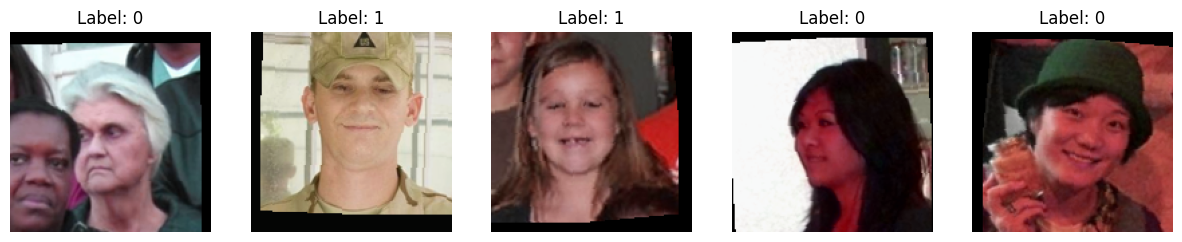

Memory Usage: 4.9%
Skipping fold 1
Skipping fold 2
Skipping fold 3
Skipping fold 4
Fold 5


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 0.6092, Val Loss: 0.4707, Train Acc: 0.6613, Val Acc: 0.7846
Epoch 2, Train Loss: 0.4332, Val Loss: 0.3467, Train Acc: 0.8059, Val Acc: 0.8641
Epoch 3, Train Loss: 0.3440, Val Loss: 0.2864, Train Acc: 0.8575, Val Acc: 0.9062
Epoch 4, Train Loss: 0.2588, Val Loss: 0.2720, Train Acc: 0.8958, Val Acc: 0.8973
Epoch 5, Train Loss: 0.2051, Val Loss: 0.1842, Train Acc: 0.9198, Val Acc: 0.9413
Epoch 6, Train Loss: 0.1840, Val Loss: 0.1753, Train Acc: 0.9286, Val Acc: 0.9363
Epoch 7, Train Loss: 0.1654, Val Loss: 0.1485, Train Acc: 0.9360, Val Acc: 0.9436
Epoch 8, Train Loss: 0.1535, Val Loss: 0.1350, Train Acc: 0.9402, Val Acc: 0.9523
Epoch 9, Train Loss: 0.1451, Val Loss: 0.1245, Train Acc: 0.9442, Val Acc: 0.9532
Epoch 10, Train Loss: 0.1396, Val Loss: 0.1162, Train Acc: 0.9467, Val Acc: 0.9586
Epoch 11, Train Loss: 0.1302, Val Loss: 0.1323, Train Acc: 0.9501, Val Acc: 0.9486
Epoch 12, Train Loss: 0.1277, Val Loss: 0.1058, Train Acc: 0.9518, Val Acc: 0.9596
Epoch 13, Tra

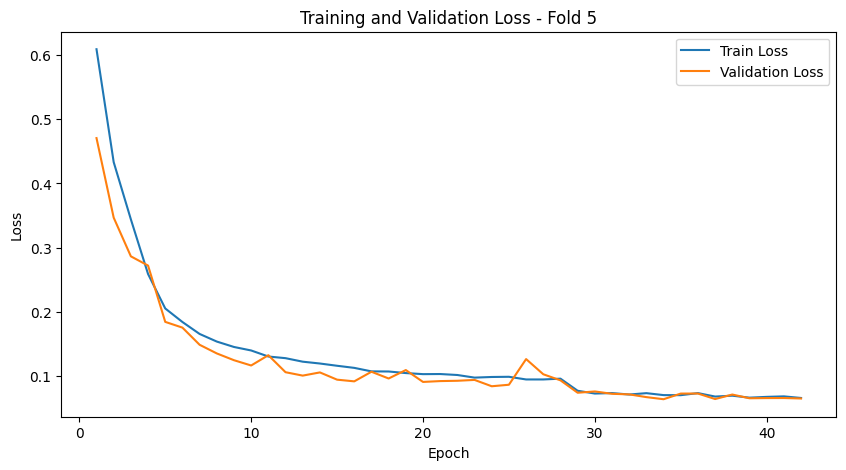

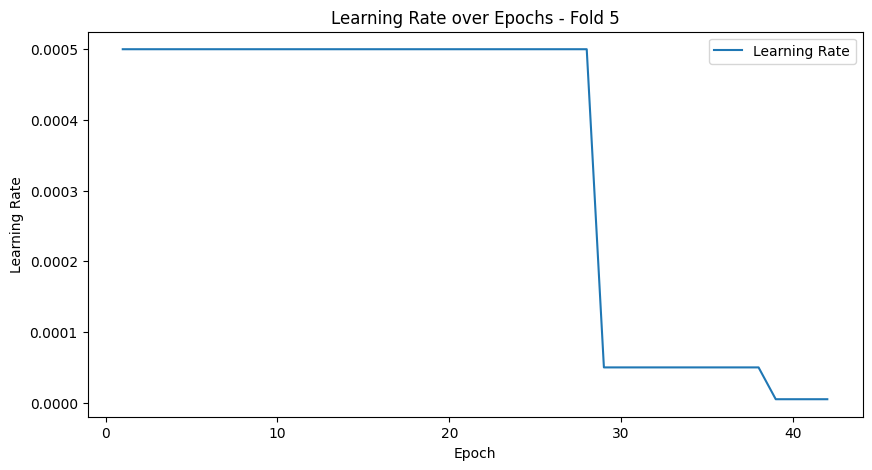

<ipython-input-1-4bbf731d8f92>:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_fold{fold + 1}.pth"))


Sample Predictions on test dataset - Fold 5


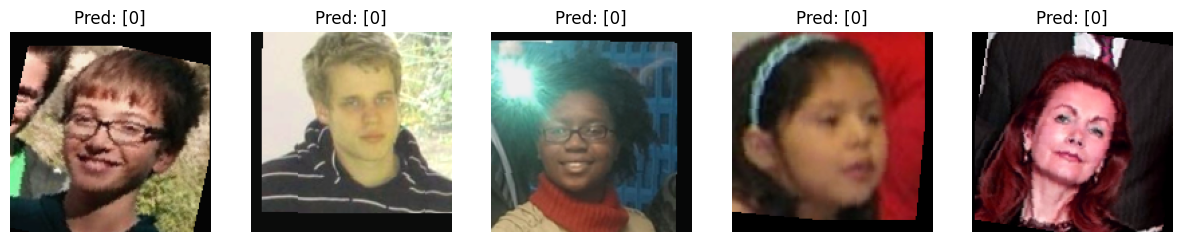

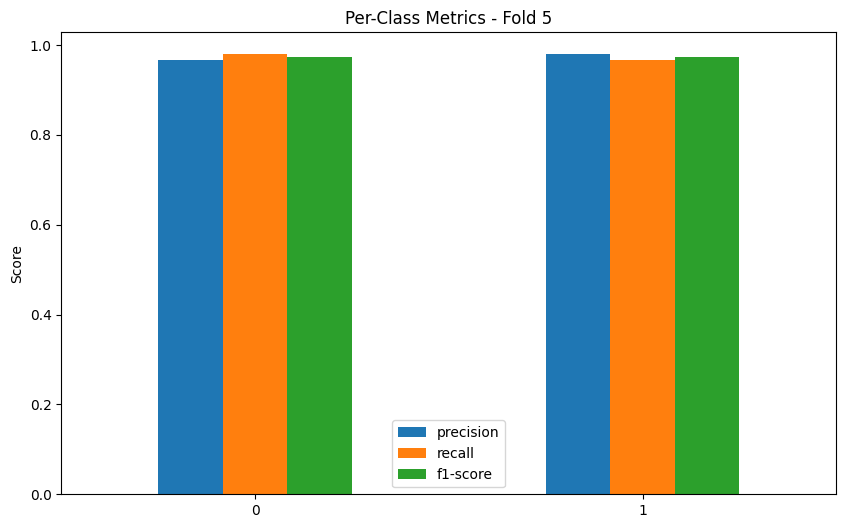

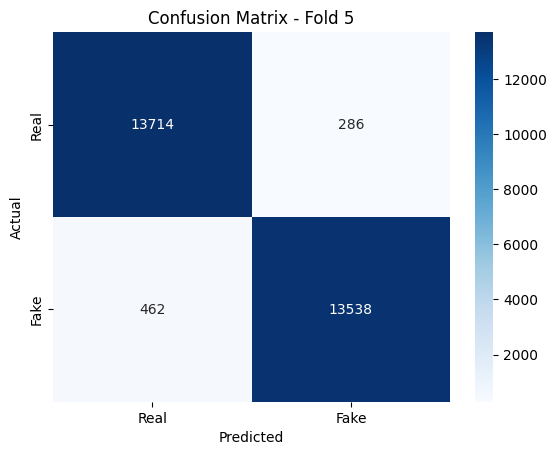

Memory Usage: 6.5%
    Classifier   Set  Fold  Accuracy  Precision    Recall  F1-score
0  ImprovedCNN  Test     5  0.973286   0.973361  0.973286  0.973285
Final model saved as final_trained_model.pth


In [1]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import gc
import psutil
from IPython.display import clear_output


def clear_memory():
    """Clears memory to prevent out-of-memory errors"""
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Memory Usage: {psutil.virtual_memory().percent}%")
    
clear_memory()

# Step 1: Dataset and DataLoader
class ImageDataset(Dataset):
    def __init__(self, image_dir, label, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for file_name in os.listdir(image_dir):
            file_path = os.path.join(image_dir, file_name)
            if file_name.endswith(('.jpg', '.png', '.jpeg')):
                self.image_paths.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations - more robust
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet Normalization
])

# Step 3: Paths to Test/Real and Test/Fake
test_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train"
real_dir = os.path.join(test_dir, "Real")
fake_dir = os.path.join(test_dir, "Fake")

# Verify the existence of directories
if not os.path.exists(real_dir):
    raise FileNotFoundError(f"Real directory not found: {real_dir}")
if not os.path.exists(fake_dir):
    raise FileNotFoundError(f"Fake directory not found: {fake_dir}")

# Count the number of images in each directory
num_real_images = len([f for f in os.listdir(real_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_fake_images = len([f for f in os.listdir(fake_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

# Print information
print(f"Found {num_real_images} Real images in directory: {real_dir}")
print(f"Found {num_fake_images} Fake images in directory: {fake_dir}")

# Dataset
real_dataset = ImageDataset(real_dir, 0, transform)
fake_dataset = ImageDataset(fake_dir, 1, transform)

dataset = real_dataset + fake_dataset
labels = real_dataset.labels + fake_dataset.labels

# Display sample images before training
def display_sample_images(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Unnormalize
        image = np.clip(image, 0, 1)  # Clip pixel values to [0, 1]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()
print("Sample Images Before Training:")
display_sample_images(dataset)

clear_memory()
# Step 2: Stratified 5-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Step 4: CNN Model (Improved)
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        # Convolutional layers with batch norm and ReLU
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       

        # Calculate size dynamically based on output of convolutions
        test_tensor = torch.randn(1, 3, 150, 150)
        conv_output_size = self.get_conv_output_size(test_tensor)

        # Fully connected layers with ReLU
        self.fc1 = nn.Linear(conv_output_size, 512) #remove batchnorm
        self.fc2 = nn.Linear(512, 128) #remove batchnorm
        self.fc3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)

    def get_conv_output_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        return x.size(1)

    def forward(self, x):
        # Convolutional layers with Batch Norm and ReLU
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  # flatten
        # Fully connected layers with  ReLU
        x = torch.relu(self.fc1(x)) #remove batchnorm
        x = self.dropout(x)
        x = torch.relu(self.fc2(x)) #remove batchnorm
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Start from the 3rd fold (index 2) ---
for fold, (train_idx, test_idx) in enumerate(kf.split(dataset, labels)):
    if fold < 4:  # Skip the first two folds
        print(f"Skipping fold {fold + 1}")
        continue

    print(f"Fold {fold + 1}")
    train_subset = Subset(dataset, train_idx)
    test_subset = Subset(dataset, test_idx)

    val_size = int(0.05 * len(train_subset))
    train_size = len(train_subset) - val_size
    train_subset, val_subset = torch.utils.data.random_split(train_subset, [train_size, val_size])

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_subset, batch_size=16, shuffle=False, num_workers=2)

    model = ImprovedCNN().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3,
                                  verbose=True)

    best_val_loss = float('inf')
    patience = 8
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    learning_rates = []


    for epoch in range(200):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels.unsqueeze(1)).sum().item()


        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images)
                loss = criterion(outputs, labels.unsqueeze(1))
                val_loss += loss.item()

                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels.unsqueeze(1)).sum().item()
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        learning_rates.append(optimizer.param_groups[0]['lr'])



        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_fold{fold + 1}.pth")
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Loss - Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(epochs, learning_rates, label='Learning Rate')
    plt.title(f'Learning Rate over Epochs - Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(f"best_model_fold{fold + 1}.pth"))
    model.eval()
    
    preds, actuals = [], []
    sample_images = []
    sample_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds.extend((outputs > 0.5).long().cpu().numpy())
            actuals.extend(labels.numpy())
            if len(sample_images) < 5:
                sample_images.extend(images.cpu().numpy())
                sample_predictions.extend((outputs > 0.5).long().cpu().numpy())

    print(f"Sample Predictions on test dataset - Fold {fold + 1}")
    plt.figure(figsize=(15, 5))
    for i, (image, pred) in enumerate(zip(sample_images,sample_predictions)):
        if i >= 5:
          break
        image = np.transpose(image, (1, 2, 0))
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        image = np.clip(image, 0, 1)
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Pred: {pred}")
        plt.axis("off")
    plt.show()

    report = classification_report(actuals, preds, output_dict=True, zero_division=0)
    confusion = confusion_matrix(actuals, preds)

    class_names = ['0', '1']
    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df[metrics_df.index.isin(class_names)]

    if not metrics_df.empty:
        metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
        plt.title(f'Per-Class Metrics - Fold {fold+1}')
        plt.xticks(rotation=0)
        plt.ylabel('Score')
        plt.show()
    else:
        print(f"No per-class metrics to plot for fold {fold+1}. Likely one class was missing in test")

    results.append({
        "Classifier": "ImprovedCNN",
        "Set": "Test",
        "Fold": fold + 1,
        "Accuracy": report["accuracy"],
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"]
    })

    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    clear_memory()

df_results = pd.DataFrame(results)
print(df_results)
torch.save(model.state_dict(), "final_trained_model.pth")
print("Final model saved as final_trained_model.pth")